In [1]:
# Download the data.    

import pandas as pd
import numpy as np
import urllib

try:
  urllib.request.urlretrieve ("https://github.com/PacktPublishing/Python-for-Finance-Cookbook/raw/master/Datasets/credit_card_default.csv", "credit_card_default.csv")
  print('Success: downloaded credit_card_default.csv.')
except Exception as e:
  print('Data load error: ',e)

# load the data into a dataframe with null values as blanks
try:
  df = pd.read_csv('./credit_card_default.csv',index_col=0, na_values='')
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded credit_card_default.csv.
Success: Data loaded into dataframe.


## Implementing scikit-learn's pipelines

In [2]:
# 1. Import the libraries:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [3]:
# 2. Load the data, separate the target, and create the stratified train-test split:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')
X = df.copy()
y = X.pop('default_payment_next_month')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
# 3. Store lists of numerical/categorical features:
num_features = X_train.select_dtypes(include='number') \
              .columns.to_list()
cat_features = X_train.select_dtypes(include='object') \
              .columns.to_list()

In [5]:
# 4. Define the numerical Pipeline:
num_pipeline = Pipeline(steps=[('imputer', 
                                SimpleImputer(strategy='median'))])

In [6]:
# 5. Define the categorical Pipeline:
cat_list = [list(X_train[col].dropna().unique()) for col in
cat_features]
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, 
                                                        sparse=False,handle_unknown='error', 
                                                        drop='first'))])

In [7]:
# 6. Define the column transformer object:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

In [8]:
# 7. Create a joint Pipeline:
dec_tree = DecisionTreeClassifier(random_state=42)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', dec_tree)])

In [9]:
# 8. Fit the Pipeline to the data:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_j...
                                                                                              '4 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '5 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '6 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '8 '
                                                                                              'months']],
                                                                                 drop='first',
                                                                                 sparse=False))]),
                                                  ['sex', 'education',
                                                   'marriage',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

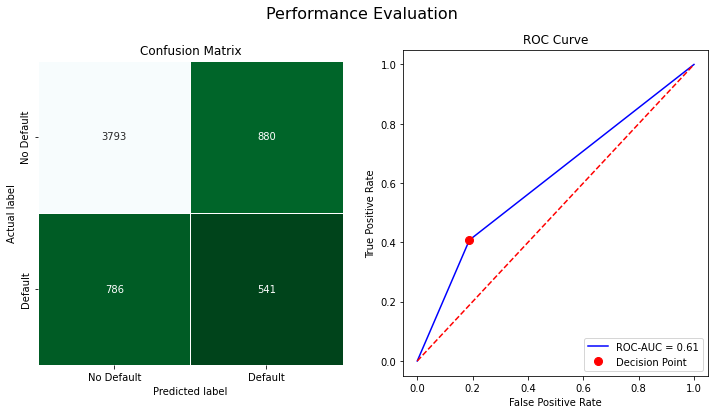

In [10]:
# 9. Evaluate the performance of the entire Pipeline:

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test,y_test, labels=LABELS, show_plot=True)

## Remove outliers


In [11]:
# how to create a custom transformer to detect and modify outliers.
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
class OutlierRemover(BaseEstimator, TransformerMixin):
                def __init__(self, n_std=3):
                    self.n_std = n_std
                def fit(self, X, y = None):
                    if np.isnan(X).any(axis=None):
                        raise ValueError('''There are missing values in the array! Please remove them.''')
                    mean_vec = np.mean(X, axis=0)
                    std_vec = np.std(X, axis=0)
                    self.upper_band_ = mean_vec + self.n_std * std_vec
                    self.lower_band_ = mean_vec - self.n_std * std_vec
                    self.n_features_ = len(self.upper_band_)
                    return self
                def transform(self, X, y = None):
                    X_copy = pd.DataFrame(X.copy())
                    upper_band = np.repeat(
                    self.upper_band_.reshape(self.n_features_, -1),
                    len(X_copy),
                    axis=1).transpose()
                    lower_band = np.repeat(
                        self.lower_band_.reshape(self.n_features_, -1),
                        len(X_copy),
                        axis=1).transpose()
                    X_copy[X_copy >= upper_band] = upper_band
                    X_copy[X_copy <= lower_band] = lower_band
                    return X_copy.values


In [13]:
# 3. Add the OutlierRemover to the numerical Pipeline:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                               ('outliers', OutlierRemover())])

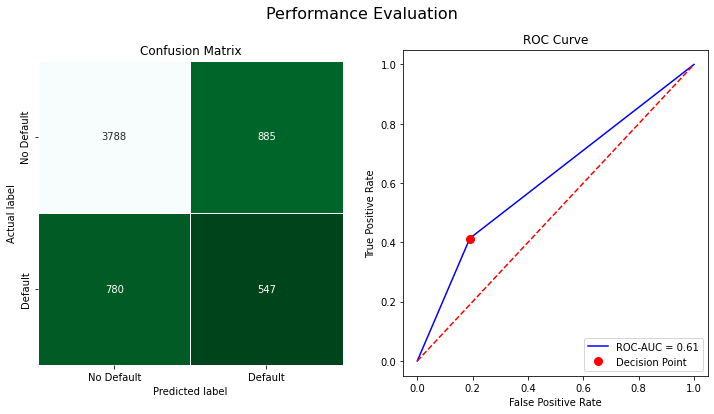

In [14]:
# 4. Run the rest of the Pipeline, to compare the results:
preprocessor = ColumnTransformer(transformers=[
   ('numerical', num_pipeline, num_features),
   ('categorical', cat_pipeline, cat_features)],
   remainder='drop')
dec_tree = DecisionTreeClassifier(random_state=42)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', dec_tree)])
tree_pipeline.fit(X_train, y_train)
tree_perf = performance_evaluation_report(tree_pipeline, X_test,
                                         y_test, labels=LABELS, show_plot=True)


## Tuning hyperparameters using grid searches and cross-validation

#### Hyperparameters:
1. External characteristic of the model Not estimated based on data
1. Can be considered the model's settings Set before the training phase
1. Tuning them can result in better performance 

#### Parameters:
1. Internal characteristic of the model
1. Estimated based on data, for example, the coefficients of linear regression 
1. Learned during the training phase

In [15]:
# 1. Import the libraries:
from sklearn.model_selection import (GridSearchCV, 
                                     cross_val_score,
                                     RandomizedSearchCV, 
                                     cross_validate, 
                                     StratifiedKFold)

In [16]:
# 2. Define a cross-validation scheme:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [17]:
# 3. Evaluate the Pipeline using cross-validation:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)


array([0.72145833, 0.72916667, 0.73583333, 0.71916667, 0.719375  ])

In [18]:
# 4. Add extra metrics to the cross-validation:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

{'fit_time': array([0.35585403, 0.33785272, 0.3366673 , 0.341429  , 0.33353424]),
 'score_time': array([0.02926803, 0.02607918, 0.0307467 , 0.02997088, 0.02860975]),
 'test_accuracy': array([0.72145833, 0.72916667, 0.73583333, 0.71916667, 0.719375  ]),
 'test_precision': array([0.38115817, 0.39469027, 0.40836299, 0.37798635, 0.37047101]),
 'test_recall': array([0.41525424, 0.41996234, 0.43220339, 0.41713748, 0.38548539]),
 'test_roc_auc': array([0.61161933, 0.6184108 , 0.62784854, 0.61172664, 0.59994054])}

In [19]:
# 5. Define the parameter grid:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
             'classifier__max_depth': range(3, 11),
             'classifier__min_samples_leaf': range(2, 11),
             'preprocessor__numerical__outliers__n_std': [3, 4]}

In [20]:
# 6. Run the grid search:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,
                            scoring='recall',
                            cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['limit_bal',
                                                                          'age',
                                                                          'bill_statement_sep',
                                                                          'bill_statement_aug',
                                                                          'bill_statement_jul',
                                                                          'bill_statement...
                                                                          'payment_status_jul',
                                                                          'payment_status_jun',
                                                                          'payment_status_may',
                                                                          'payment_status_apr'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11),
                         'preprocessor__numerical__outliers__n_std': [3, 4]},
             scoring='recall', verbose=1)

In [21]:
print(f'Best parameters: {classifier_gs.best_params_}')
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}')
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 9, 'classifier__min_samples_leaf': 9, 'preprocessor__numerical__outliers__n_std': 4}
Recall (Training set): 0.3724
Recall (Test set): 0.3549


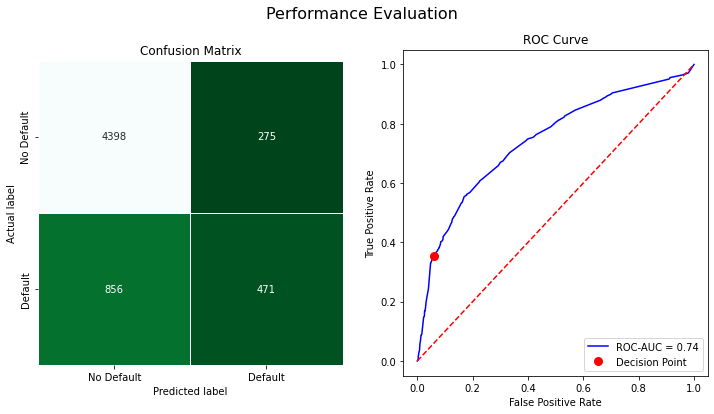

In [22]:
# 7. Evaluate the performance of the grid search:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test,
                                            y_test, labels=LABELS,
                                            show_plot=True)

In [23]:
# 8. Run the randomized grid search:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid,
                                  scoring='recall',
                                  cv=k_fold, n_jobs=-1, verbose=1,
                                  n_iter=100, random_state=42)

classifier_rs.fit(X_test, y_test)

print(f'Best parameters: {classifier_rs.best_params_}')
print(f'Recall (Training set): {classifier_rs.best_score_:.4f}')
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'preprocessor__numerical__outliers__n_std': 3, 'classifier__min_samples_leaf': 6, 'classifier__max_depth': 7, 'classifier__criterion': 'gini'}
Recall (Training set): 0.3730
Recall (Test set): 0.4318
